# Data Prepocessing & Modelling

## Reading in Data, Cleaning Data and adding actual values for visualizations

In [1]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display
# Import functions from own Python-File (see visuals.py in Repo)
import visuals as vs

pd.set_option('display.max_columns', None) # To display all columns
import xlrd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
sns.set_style("whitegrid")

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df = pd.read_excel('Data/drug_consumption.xls')

We delete every row where a participant indicated the use of 'Semeron', which is a fictional, non existing drug, used to pick out individuals who are exaggerating their drug use:

In [3]:
# df.loc[df["Semer"] != "CL0"]                    have a look at the 8 lines with Semeron consumption
df1 = df.drop(df.loc[df["Semer"] != "CL0"].index)
df1.drop('Semer', inplace=True, axis=1)

Reassigning categorical features to standardized Values for Gender, Country, Education, Etnicity & Age for better visualizations

In [4]:
Gencat = df1['Gender'].apply(lambda x: 1 if x > 0 else 0)
df1["Gender"] = Gencat
df1["Gender"] = df1["Gender"].astype("category")

In [5]:
Countrycat = df1['Country'].apply(lambda x: {(-0.09765):'Australia', 
                                             0.24923:'Canada',
                                             0.96082:'UK',
                                            (-0.46841):'New Zealand',
                                            (-0.28519):'Other',
                                            (0.21128):'R.o.Ireland',
                                            (-0.57009):'USA'}.get(x,''))
df1.insert(5, "Country_Name", Countrycat)
df1["Country_Name"] = df1["Country_Name"].astype("category")

In [6]:
Educat = df1['Education'].apply(lambda x: {(-2.43591): "under 16y",
                                           (-1.73790): "16y",
                                           (-1.43719): "17y",
                                           (-1.22751): '18y',
                                           (-0.61113):'College/Uni',
                                           (-0.05921):'Cert./Diploma',
                                           (0.45468): 'Uni Degree', 
                                           (1.16365):'Master',
                                           (1.98437): 'PhD'}.get(x,''))
df1.insert(4, "Education_Level", Educat)
df1["Education_Level"] = df1["Education_Level"].astype("category")

In [7]:
Ethinicitycat = df1["Ethnicity"].apply(lambda x: {(-0.50212): "Asian",
                                           (-1.10702): "Black",
                                           (1.90725): "Mixed-Black/Asian",
                                           (0.12600): 'Mixed-White/Asian',
                                           (-0.22166):'Mixed-White/Black',
                                           (0.11440):'Other',
                                           (-0.31685): 'White'}.get(x,''))
df1.insert(8, "Ethnicity_Label", Ethinicitycat)
df1["Ethnicity_Label"] = df1["Ethnicity_Label"].astype("category")

In [8]:
Agecat = df1["Age"].apply(lambda x: {(-0.95197): "18-24",
                                           (-0.07854): "25-34",
                                           (0.49788): "35-44",
                                           (1.09449): '45-54',
                                           (1.82213):'55-64',
                                           (2.59171):'65+'}.get(x,''))
df1.insert(2, "Age_Cat", Agecat)
df1["Age_Cat"] = df1["Age_Cat"].astype("category")

## Classification of drug usage in users and non-users

Formally, the only individuals who can be considered non-users are individuals in Class 0, however individuals who used a drug more than a decade ago cannot be considered a drug user for most applications.
There are several possible way to discriminate participants into groups of users and non-users for binary classification. We decided to define non-user as anyone who has never taken the drug (CL0) or taken the drug over a decade ago (CL1) and anyone else as a user (CL2, CL3, CL4, CL5 and CL6).

In [9]:
drugs = ["Alcohol", "Amphet", "Amyl", "Benzos", "Caff", "Cannabis", "Choc", "Coke", "Crack",
        "Ecstasy", "Heroin", "Ketamine", "Legalh", "LSD", "Meth", "Shrooms", "Nicotine", "VSA"]

for element in drugs:
    column_insert = df1.columns.get_loc(element)+1
    col_name = element+"_Cat"
    cat = df1[element].apply(lambda x: 0 if (x == "CL0" or x == "CL1") else 1)
    df1.insert(column_insert, col_name, cat)
    df1[col_name] = df1[col_name].astype("category")

## Categorizing the different drugs into 3 groups

In [10]:
drugs_cat = ["Alcohol_Cat", "Amphet_Cat", "Amyl_Cat", "Benzos_Cat", "Caff_Cat", "Cannabis_Cat", "Choc_Cat", "Coke_Cat", "Crack_Cat",
        "Ecstasy_Cat", "Heroin_Cat", "Ketamine_Cat", "Legalh_Cat", "LSD_Cat", "Meth_Cat", "Shrooms_Cat", "Nicotine_Cat", "VSA_Cat"]

user_total = []
non_user_total = []

for element in drugs_cat:
    user = df1[element].value_counts(normalize=True).sort_index()[1]
    non_user = df1[element].value_counts(normalize=True).sort_index()[0]
    user_total.append(user)
    non_user_total.append(non_user)

total_user = pd.DataFrame([drugs_cat, user_total, non_user_total], index=["Drug", "User", "Non_user"]).T

First group are all drugs with a user base of over 66%, we specify those as "social drugs"

In [11]:
total_user.query("User > 0.66")

,Drug,User,Non_user
0,Alcohol_Cat,0.964305,0.0356953
4,Caff_Cat,0.980288,0.0197123
5,Cannabis_Cat,0.669686,0.330314
6,Choc_Cat,0.981886,0.018114
16,Nicotine_Cat,0.669153,0.330847


Second group are all drugs with a user base under 66% but above 25%, we specify those as "party drugs"

In [12]:
total_user.query("User < 0.66 and User > 0.25")

,Drug,User,Non_user
1,Amphet_Cat,0.359084,0.640916
3,Benzos_Cat,0.405967,0.594033
7,Coke_Cat,0.362813,0.637187
9,Ecstasy_Cat,0.39691,0.60309
12,Legalh_Cat,0.40277,0.59723
13,LSD_Cat,0.293554,0.706446
15,Shrooms_Cat,0.36601,0.63399


Third group are all drugs with a user base under 25%, we specify those as "hard drugs"

In [13]:
total_user.query("User < 0.25")

,Drug,User,Non_user
2,Amyl_Cat,0.196058,0.803942
8,Crack_Cat,0.10016,0.89984
10,Heroin_Cat,0.111348,0.888652
11,Ketamine_Cat,0.184337,0.815663
14,Meth_Cat,0.220565,0.779435
17,VSA_Cat,0.120405,0.879595


Making a dataframe for each ob the drug subgroups:

In [14]:
df_group1_drugs = df1.drop(["Amphet_Cat", "Amyl_Cat", "Benzos_Cat", "Coke_Cat", "Crack_Cat", "Ecstasy_Cat", 'Heroin_Cat', 'Ketamine_Cat',
                       'Legalh_Cat', 'LSD_Cat', 'Meth_Cat', 'Shrooms_Cat', 'VSA_Cat', 'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 
                       'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Shrooms',
                       'Nicotine', 'VSA'], axis=1)

df_group2_drugs = df1.drop(["Alcohol_Cat", "Amyl_Cat", "Caff_Cat", "Cannabis_Cat", "Choc_Cat", "Crack_Cat",
        "Heroin_Cat", "Ketamine_Cat", "Meth_Cat", "Nicotine_Cat", "VSA_Cat", "Alcohol", "Amphet", "Amyl", "Benzos", "Caff", "Cannabis", "Choc", "Coke", "Crack",
        "Ecstasy", "Heroin", "Ketamine", "Legalh", "LSD", "Meth", "Shrooms", "Nicotine", "VSA"], axis=1)

df_group3_drugs = df1.drop(["Alcohol_Cat", "Amphet_Cat", "Benzos_Cat", "Caff_Cat", "Cannabis_Cat", "Choc_Cat", "Coke_Cat",
        "Ecstasy_Cat", "Legalh_Cat", "LSD_Cat", "Shrooms_Cat", "Nicotine_Cat", "Alcohol", "Amphet", "Amyl", "Benzos", "Caff", "Cannabis", "Choc", "Coke", "Crack",
        "Ecstasy", "Heroin", "Ketamine", "Legalh", "LSD", "Meth", "Shrooms", "Nicotine", "VSA"], axis=1)

Changing the binary classification to integers for each of the drugs in the 3 drug subgroup dataframes:

In [15]:
# "Social drugs"
df_group1_drugs["Alcohol_Cat"] = df_group1_drugs["Alcohol_Cat"].astype(int)
df_group1_drugs["Caff_Cat"] = df_group1_drugs["Caff_Cat"].astype(int)
df_group1_drugs["Cannabis_Cat"] = df_group1_drugs["Cannabis_Cat"].astype(int)
df_group1_drugs["Choc_Cat"] = df_group1_drugs["Choc_Cat"].astype(int)
df_group1_drugs["Nicotine_Cat"] = df_group1_drugs["Nicotine_Cat"].astype(int)

# "Party drugs"
df_group2_drugs["Amphet_Cat"] = df_group2_drugs["Amphet_Cat"].astype(int)
df_group2_drugs["Benzos_Cat"] = df_group2_drugs["Benzos_Cat"].astype(int)
df_group2_drugs["Coke_Cat"] = df_group2_drugs["Coke_Cat"].astype(int)
df_group2_drugs["Ecstasy_Cat"] = df_group2_drugs["Ecstasy_Cat"].astype(int)
df_group2_drugs["Legalh_Cat"] = df_group2_drugs["Legalh_Cat"].astype(int)
df_group2_drugs["LSD_Cat"] = df_group2_drugs["LSD_Cat"].astype(int)
df_group2_drugs["Shrooms_Cat"] = df_group2_drugs["Shrooms_Cat"].astype(int)

# "Hard drugs"
df_group3_drugs["Amyl_Cat"] = df_group3_drugs["Amyl_Cat"].astype(int)
df_group3_drugs["Crack_Cat"] = df_group3_drugs["Crack_Cat"].astype(int)
df_group3_drugs["Heroin_Cat"] = df_group3_drugs["Heroin_Cat"].astype(int)
df_group3_drugs["Ketamine_Cat"] = df_group3_drugs["Ketamine_Cat"].astype(int)
df_group3_drugs["Meth_Cat"] = df_group3_drugs["Meth_Cat"].astype(int)
df_group3_drugs["VSA_Cat"] = df_group3_drugs["VSA_Cat"].astype(int)

Assigning user or non-user (1 or 0) for each of the drug groups and storing this in a few dataframe:

In [16]:
df2 = df1.copy()

In [17]:
drugs1=["Alcohol_Cat", "Caff_Cat", "Cannabis_Cat", "Choc_Cat", "Nicotine_Cat"]
df2['Social_Drugs']= df_group1_drugs["Alcohol_Cat"] + df_group1_drugs["Caff_Cat"] + df_group1_drugs["Cannabis_Cat"] + df_group1_drugs["Choc_Cat"] + df_group1_drugs["Nicotine_Cat"]
df2['Social_Drugs'] = df2['Social_Drugs'].apply(lambda x: 1 if x > 0 else 0)

drugs2=["Amphet_Cat", "Benzos_Cat", "Coke_Cat", "Ecstasy_Cat", "Legalh_Cat", "LSD_Cat", "Shrooms_Cat"]
df2['Party_Drugs']= df_group2_drugs["Amphet_Cat"] + df_group2_drugs["Benzos_Cat"] + df_group2_drugs["Coke_Cat"] + df_group2_drugs["Ecstasy_Cat"] + df_group2_drugs["Legalh_Cat"] + df_group2_drugs["LSD_Cat"]+ df_group2_drugs["Shrooms_Cat"]
df2['Party_Drugs'] = df2['Party_Drugs'].apply(lambda x: 1 if x > 0 else 0)

drugs3=["Amyl_Cat", "Crack_Cat", "Heroin_Cat", "Ketamine_Cat", "Meth_Cat", "VSA_Cat"]
df2['Hard_Drugs']= df_group3_drugs["Amyl_Cat"] + df_group3_drugs["Crack_Cat"] + df_group3_drugs["Heroin_Cat"] + df_group3_drugs["Ketamine_Cat"] + df_group3_drugs["Meth_Cat"] + df_group3_drugs["VSA_Cat"]
df2['Hard_Drugs'] = df2['Hard_Drugs'].apply(lambda x: 1 if x > 0 else 0)

df2.drop(["Alcohol", "Amphet", "Amyl", "Benzos", "Caff", "Cannabis", "Choc", "Coke", "Crack","Ecstasy", "Heroin", "Ketamine",
          "Legalh", "LSD", "Meth", "Shrooms", "Nicotine", "VSA", "Alcohol_Cat", "Amphet_Cat", "Amyl_Cat", "Benzos_Cat", "Caff_Cat",
          "Cannabis_Cat", "Choc_Cat", "Coke_Cat", "Crack_Cat","Ecstasy_Cat", "Heroin_Cat", "Ketamine_Cat", "Legalh_Cat", "LSD_Cat", 
          "Meth_Cat", "Shrooms_Cat", "Nicotine_Cat", "VSA_Cat"], axis=1, inplace=True)

Check Workfile for modelling and export new dataset to csv.

In [18]:
# df2.to_csv('data/drug_workfile')
df2

,ID,Age,Age_Cat,Gender,Education,Education_Level,Country,Country_Name,Ethnicity,Ethnicity_Label,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Social_Drugs,Party_Drugs,Hard_Drugs
0,1,0.49788,35-44,1,-0.05921,Cert./Diploma,0.96082,UK,0.12600,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,1,1,0
1,2,-0.07854,25-34,0,1.98437,PhD,0.96082,UK,-0.31685,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1,1,1
2,3,0.49788,35-44,0,-0.05921,Cert./Diploma,0.96082,UK,-0.31685,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,1,0,0
3,4,-0.95197,18-24,1,1.16365,Master,0.96082,UK,-0.31685,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1,1,1
4,5,0.49788,35-44,1,1.98437,PhD,0.96082,UK,-0.31685,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,1884,-0.95197,18-24,1,-0.61113,College/Uni,-0.57009,USA,-0.31685,White,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,1,1,1
1881,1885,-0.95197,18-24,0,-0.61113,College/Uni,-0.57009,USA,-0.31685,White,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,1,1,1
1882,1886,-0.07854,25-34,1,0.45468,Uni Degree,-0.57009,USA,-0.31685,White,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,1,1,1
1883,1887,-0.95197,18-24,1,-0.61113,College/Uni,-0.57009,USA,-0.31685,White,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,1,1,0


# Modelling with Decision Tree 

We want to predict wether a certain person is suitable for our predefined drugclusters because of his personality traits.
Furthermore we focus on a high Precision because we do not want our model to predict the suitability for a wrong cluster of drugs, e.g. we do not want to offer chocolate to a crackhead or meth to a pothead.

Import Workfile:

In [19]:
wf = pd.read_csv('data/drug_workfile')
wf.head()

,Unnamed: 0,ID,Age,Age_Cat,Gender,Education,Education_Level,Country,Country_Name,Ethnicity,Ethnicity_Label,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Social_Drugs,Party_Drugs,Hard_Drugs
0,0,1,0.49788,35-44,1,-0.05921,Cert./Diploma,0.96082,UK,0.12600,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,1,1,0
1,1,2,-0.07854,25-34,0,1.98437,PhD,0.96082,UK,-0.31685,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1,1,1
2,2,3,0.49788,35-44,0,-0.05921,Cert./Diploma,0.96082,UK,-0.31685,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,1,0,0
3,3,4,-0.95197,18-24,1,1.16365,Master,0.96082,UK,-0.31685,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1,1,1
4,4,5,0.49788,35-44,1,1.98437,PhD,0.96082,UK,-0.31685,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,1,1,0


In [20]:
# TODO: Total number of participants
n_participants = len(wf)

# TODO: Number of records where participants's took drugs of "Social" class
n_participants_social = len(wf[wf['Party_Drugs'] == 1])

# TODO: Number of records where participants's took drugs of "Social" class
n_participants_nosocial = len(wf[wf['Party_Drugs'] == 0])

# TODO: Percentage of participants's who took drugs of "Social" class
greater_percent = 100 * n_participants_social / n_participants

#### Feature Selection:

In [21]:
X = wf[['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Social_Drugs', 'Hard_Drugs']]
y = wf['Party_Drugs']

In [22]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y) 

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1313 samples.
Testing set has 564 samples.


#### Naive Preditor

In [23]:
# TODO: Calculate accuracy
accuracy = n_participants_social / n_participants

# Calculating precision
precision = n_participants_social / (n_participants_social + n_participants_nosocial)

#Calculating recall (naive prediction because we assume there are no False Negatives)
recall = n_participants_social / (n_participants_social + 0)

# TODO: Calculate F-score using the formula above for beta = 0.5
fscore =  (1  + (0.5*0.5)) * ( precision * recall / (( 0.5*0.5 * (precision))+ recall))

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.6462, F-score: 0.6954]


In [24]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [25]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# TODO: Initialize the three models, the random states are set to 420 so we know how to reproduce the model later
clf_A = DecisionTreeClassifier(random_state = 420)
clf_B = SVC(random_state = 420)
clf_C = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state = 420)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

DecisionTreeClassifier trained on 13 samples.
DecisionTreeClassifier trained on 131 samples.
DecisionTreeClassifier trained on 1313 samples.
SVC trained on 13 samples.
SVC trained on 131 samples.
SVC trained on 1313 samples.
AdaBoostClassifier trained on 13 samples.
AdaBoostClassifier trained on 131 samples.
AdaBoostClassifier trained on 1313 samples.


/Users/sebastianrotten/neuefische/Personality_vs_drug_use/visuals.py:87: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


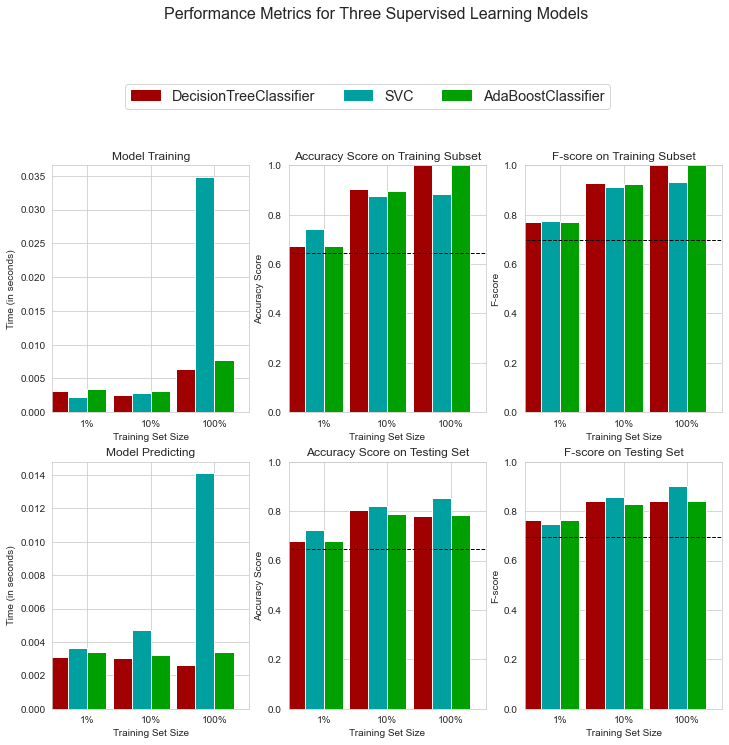

In [26]:
# Run metrics visualization for the two supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [27]:
#Printing out the values
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

DecisionTreeClassifier


,1%,10%,100%
train_time,0.003165,0.002622,0.006338
pred_time,0.003114,0.003057,0.002633
acc_train,0.673333,0.903333,1.000000
acc_test,0.680851,0.803191,0.780142
f_train,0.768817,0.929423,1.000000
f_test,0.762411,0.842275,0.840069


SVC


,1%,10%,100%
train_time,0.002255,0.002910,0.034815
pred_time,0.003615,0.004741,0.014087
acc_train,0.743333,0.873333,0.883333
acc_test,0.721631,0.820922,0.854610
f_train,0.774478,0.910463,0.931579
f_test,0.749570,0.855687,0.900693


AdaBoostClassifier


,1%,10%,100%
train_time,0.003447,0.003089,0.007755
pred_time,0.003379,0.003201,0.003382
acc_train,0.673333,0.896667,1.000000
acc_test,0.680851,0.789007,0.783688
f_train,0.768817,0.922091,1.000000
f_test,0.762411,0.828059,0.839002


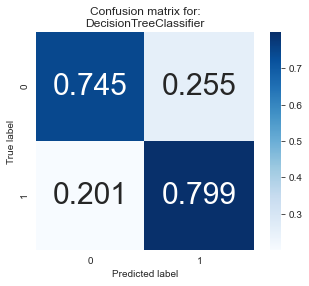

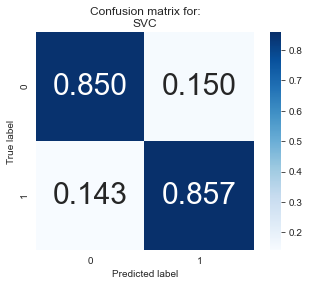

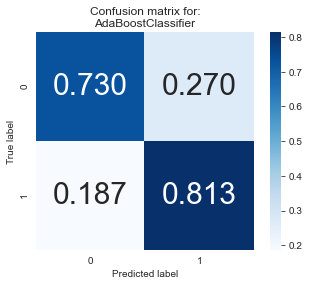

In [28]:
#Visualizing the confusion matrix for each classifier
from sklearn.metrics import confusion_matrix

for i,model in enumerate([clf_A,clf_B,clf_C]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

Looking at the results above, out of the three models, AdaBoost is the most appropriate for our task.

First and foremost, it is the classifier that performs the best on the testing data, in terms of both the accuracy and f0.5-score which we already weighted towards a higher importance regarding precision. It also takes reasonably low time to train on the full dataset, even if there are no big timing differences to our 2nd best model (Adaboost).

## Gridsearch for SVC

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'kernel': ['rbf', 'sigmoid'], 
               'gamma': [0.01, 0.05, 0.1, 1, 10],
               'C': [0.1, 0.05, 1, 5, 10]},
              {'kernel': ['linear'], 
               'C': [0.1, 0.05, 1, 5, 10]}]

#param_grid = [{'kernel': ['rbf', 'sigmoid'], 
#               'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
#               'C': [1, 10, 100, 1000]},
#              {'kernel': ['linear'], 
#               'C': [1, 10, 100, 1000]}]

grid = GridSearchCV(clf_B, param_grid, verbose=True, n_jobs=-1)

result = grid.fit(X_train, y_train)

# Get the estimator
best_clf = result.best_estimator_ 

# Make predictions using the unoptimized and model
predictions_svc = (clf_B.fit(X_train, y_train)).predict(X_test)
best_predictions_svc = best_clf.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions_svc)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions_svc, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions_svc)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions_svc, beta = 0.5)))
print(best_clf)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s


Unoptimized model
------
Accuracy score on testing data: 0.8546
F-score on testing data: 0.9007

Optimized Model
------
Final accuracy score on the testing data: 0.8457
Final F-score on the testing data: 0.8979
SVC(C=1, gamma=0.05, kernel='sigmoid', random_state=420)


[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:    3.9s finished


## Grid Search for AdaBoost

In [30]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer 


# TODO: Create the parameters list you wish to tune
parameters_ada = {'n_estimators':[60, 70, 80],                
              'learning_rate':[0.1, 0.01, 0.05],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1)              
             } 

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5) 

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf_C, parameters_ada, scorer, verbose=1, n_jobs=-1)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit_ada = grid_obj.fit(X_train,y_train) 

# Get the estimator
best_clf_ada = grid_fit_ada.best_estimator_

# Make predictions using the unoptimized and model
predictions_ada = (clf_C.fit(X_train, y_train)).predict(X_test)
best_predictions_ada = best_clf_ada.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions_ada)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions_ada, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions_ada)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions_ada, beta = 0.5)))
print(best_clf_ada)

/Users/sebastianrotten/opt/anaconda3/envs/drugs/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass scoring=make_scorer(fbeta_score, beta=0.5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.8s


Unoptimized model
------
Accuracy score on testing data: 0.7837
F-score on testing data: 0.8390

Optimized Model
------
Final accuracy score on the testing data: 0.8511
Final F-score on the testing data: 0.9069
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.01, n_estimators=60, random_state=420)


[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   16.1s finished


## Feature Importance

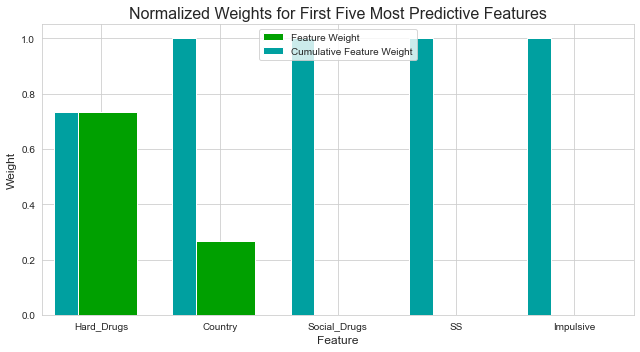

In [31]:
importances_ada = best_clf_ada.feature_importances_

# Plot
vs.feature_plot(importances_ada, X_train, y_train)